## Hubway Visualization

In [139]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
np.set_printoptions(threshold=240)
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('fivethirtyeight')

import seaborn as sns
import geoplotlib as gp

from dataset_io import get_hubway_data
from station_geography import lat_lon_to_xy
from optimize_stations import optimize_station_position

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
## Extract ride and station data
# Start with just 2015 as the data is cleaner
trips, stations = get_hubway_data(years=[2015])


In [58]:
# print("Stations shape: {:}".format(stations.shape))
# print("Trips shape: {:}".format(trips.shape))
# start_station_ids = pd.Series.unique(stations['start station id'])
# start_station_names = pd.Series.unique(stations['start station name'])
# start_station_lat = pd.Series.unique(stations['lat'])
# start_station_lon = pd.Series.unique(stations['lon'])

# print("start station ids shape: {:}".format(start_station_ids.shape))
# print("start station names shape: {:}".format(start_station_names.shape))
# print("start station lat shape: {:}".format(start_station_lat.shape))
# print("start station lon shape: {:}".format(start_station_lon.shape))
# print(np.all(np.sort(start_station_ids) == np.sort(end_station_ids)))

# print(stations.sort_values('start station id').to_string())
trips.dtypes
# trips['starttime'].head()
# stations.dtypes
# stations.shape

tripduration                      int64
starttime                datetime64[ns]
stoptime                 datetime64[ns]
start station id                  int64
start station name               object
lat                             float64
lon                             float64
end station id                    int64
end station name                 object
end station latitude             object
end station longitude            object
bikeid                            int64
usertype                         object
birth year                        int64
gender                            int64
age                               int64
dtype: object

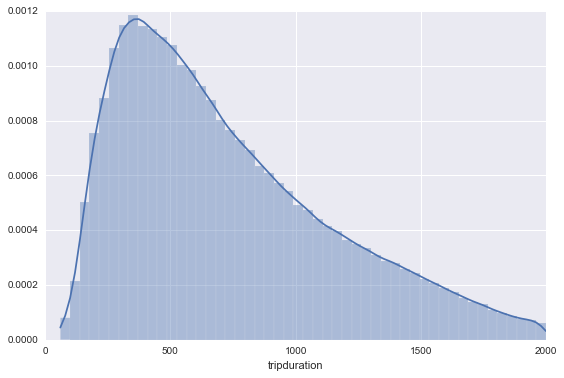

In [5]:
# This was WAY TOO SLOW, started swapping memory
# trips['start station id'].apply(pd.value_counts).plot(kind='bar', 
#                                                       subplots=True)

# start_ids = trips['start station id'].as_matrix()

sns.distplot(trips[trips['tripduration'] < 2000]['tripduration'])

/home/mattgiamou/.virtualenvs/cv3/lib/python3.4/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


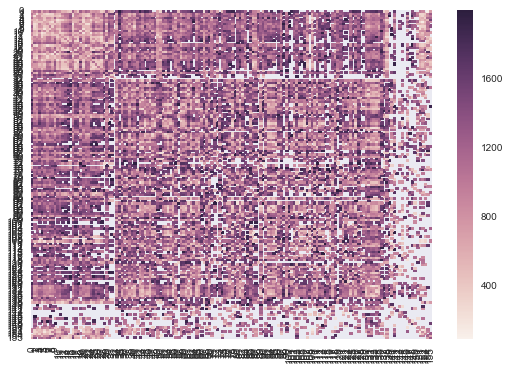

In [6]:
## Create matrix of mean inter-station trips (non symmetrical!)
# print(trips.head(20))

ids = pd.Series.unique(trips['start station id'])
time_matrix = np.zeros((len(ids), len(ids)))

for idx, a in enumerate(ids):
    for jdx, b in enumerate(ids):
        ab = trips[trips['start station id'] == a][trips['end station id'] == b]
        time_matrix[idx, jdx] = pd.Series.mean(ab[ab['tripduration'] < 2000]['tripduration'])

# ab = trips[trips['start station id'] == 115][trips['end station id'] == 88]
# sns.distplot(ab[ab['tripduration'] < 2000]['tripduration'])

sns.heatmap(time_matrix)

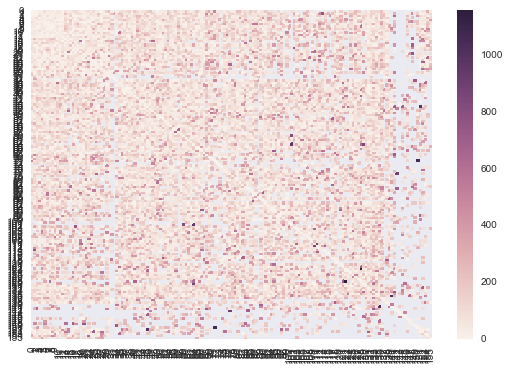

In [7]:
# Check correlation between reverse-direction trips:
time_matrix_diff = np.abs(time_matrix - time_matrix.T)
sns.heatmap(time_matrix_diff)

/home/mattgiamou/.virtualenvs/cv3/lib/python3.4/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


(137, 16)


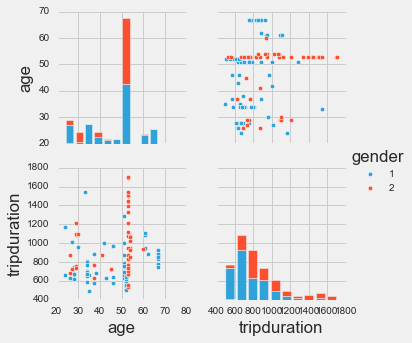

In [56]:
# Get time of day involved as well
trips_valid = trips[trips['age'] > 0][trips['tripduration'] < 2000]
# trips_valid = trips_valid[trips_valid['start station id']==23]
# trips_valid = trips_valid[trips_valid['end station id'] == 24]
trips_valid = trips_valid[trips_valid['start station id']==109]
trips_valid = trips_valid[trips_valid['end station id'] == 141]
# Might not have enough data to show traffic every 10-20 mins
print(trips_valid.shape)
sns.pairplot(trips_valid.loc[:,('age', 'tripduration', 'gender')], vars=('age', 'tripduration'), hue='gender')

In [103]:
# Remove outlier trips
max_time = 2000 
min_time = 60
trips_inlier = trips[trips['tripduration'] <= max_time]
trips_inlier = trips_inlier[trips_inlier['tripduration'] >= min_time]

# Add speed
trips_inlier['speed'] = trips_inlier['distance']/trips_inlier['tripduration']

mean_speed = trips_inlier['speed'].mean()
print("Mean speed: {:}".format(mean_speed))

# Make a time index 
time_index = pd.DatetimeIndex(trips_inlier['starttime'])
# Grab only data from between 4:00 and 4:15 pm on any day in 2015
trips_test = trips_inlier.iloc[time_index.indexer_between_time('16:00', '16:15')]
print(trips_test.shape)

# Compute mean and variance of distance with trip duration and mean speed
ids = pd.Series.unique(trips_test['start station id'])
mean_matrix = np.zeros((len(ids), len(ids)))
var_matrix = np.zeros(mean_matrix.shape)

for idx, a in enumerate(ids):
    for jdx, b in enumerate(ids):
        ab = trips_test[trips_test['start station id'] == a][trips_test['end station id'] == b]
        mean_matrix[idx, jdx] = np.mean(ab['tripduration']*mean_speed)
        var_matrix[idx, jdx] = np.var(ab['tripduration']*mean_speed)
mean_matrix = np.nan_to_num(mean_matrix)
var_matrix = np.nan_to_num(var_matrix)


Mean speed: 2.7303786018577485
(19511, 18)


/home/mattgiamou/.virtualenvs/cv3/lib/python3.4/site-packages/ipykernel/__main__.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


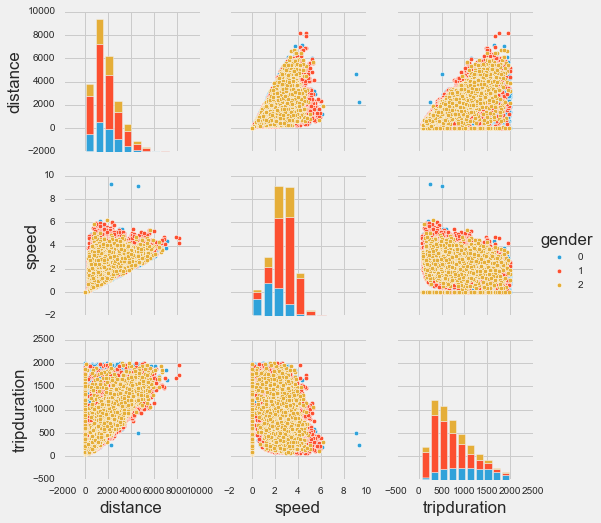

In [98]:
# Pairplot for trip duration vs time of day?
sns.pairplot(trips_test.loc[:,('distance', 'tripduration', 'speed', 'gender')], vars=('distance', 'speed', 'tripduration'), hue='gender')

In [154]:
# Optimize positions
# print(np.all(ids == pd.Series.unique(trips_test['start station id'])))
x0 = stations[stations['start station id'].isin(ids)]['x'].as_matrix()
y0 = stations[stations['start station id'].isin(ids)]['y'].as_matrix()
X = np.vstack((x0, y0)).T

print(mean_matrix.shape)
print(X.shape)
print(var_matrix.shape)
# X0 = X.reshape((1, -1)).flatten()
# print(X0.shape)

# print(X[0:5,:])
# print(X0[0:10])
# X1 = X0.reshape((-1,2))
# print(X1[0:5,:])
res2 = optimize_station_position(X, mean_matrix, var_matrix, alpha=0.01)

(155, 155)
(155, 2)
(155, 155)


In [120]:
print(np.count_nonzero(mean_matrix))
print(np.count_nonzero(var_matrix))
print(mean_matrix.shape[0]*mean_matrix.shape[1])
print(np.max(var_matrix))
print(np.min(var_matrix[var_matrix!=0.0]))

5554
3300
24025
6385554.11268
1.86374182737


(155, 2)


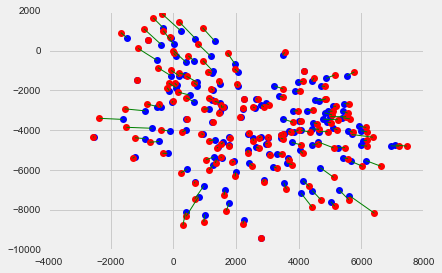

In [155]:
soln2 = res2['x'].reshape((-1,2))
print(soln2.shape)
plt.figure()
plt.plot(soln2[:,0], soln2[:,1], 'bo')
plt.plot(x0, y0, 'ro')

for idx in range(0, len(x0)):
    plt.plot([x0[idx], soln2[idx, 0]], [y0[idx], soln2[idx, 1]], 'g-', linewidth=1.0)

10
(155, 2)


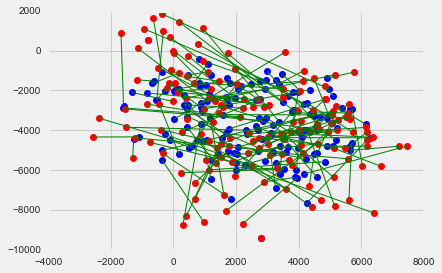

In [153]:
print(len(res))
soln = res['x'].reshape((-1,2))
print(soln.shape)
plt.figure()
plt.plot(soln[:,0], soln[:,1], 'bo')
plt.plot(x0, y0, 'ro')

for idx in range(0, len(x0)):
    plt.plot([x0[idx], soln[idx, 0]], [y0[idx], soln[idx, 1]], 'g-', linewidth=1.0)

In [135]:
## Plot locations with geoplotlib
# gp.voronoi(stations, line_color='b')
gp.delaunay(stations, cmap='BuGn')
gp.dot(stations, color='r')
# gp.graph(stations, color='g')
gp.show()
# Inline broken in Python 3.4: 
# gp.inline()

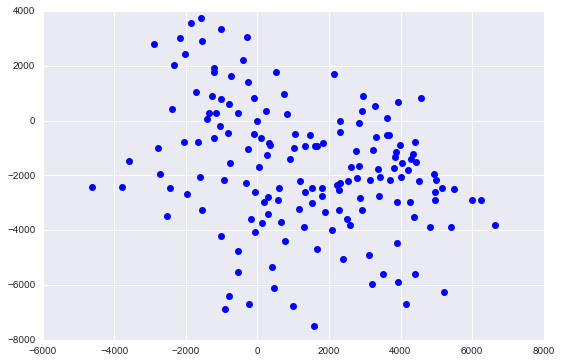

In [5]:
## Plot stations on a map
x, y = lat_lon_to_xy(lat, lon)
plt.figure()
plt.plot(x, y, 'bo')